In [1]:
import sys

sys.path.append('..')

import qiskit
import json
import numpy as np
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.circuit.library import QFT
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import canopus
import seaborn as sns

---

### Query the result

In [2]:
TOKEN = 'XmCm7IP6TTKlzpRIySwkL7ruhdMj2o0_8sqiC6Yy91ic' # My API

service = QiskitRuntimeService(
    channel="ibm_cloud",
    token = TOKEN
)


In [3]:
job_ids = json.load(open('qft_cloud_job_ids.json', 'r'))  # Load the configuration file
print(job_ids)

{'6': {'qiskit_cx': 'd2iqhquactes73f6hm7g', 'canopus_cx': 'd2iqhr6ot80s73feqm7g', 'canopus_zzphase': 'd2iqhrg3omtc738jpc00'}, '8': {'qiskit_cx': 'd2iqhtdv7m7s73ebuk20', 'canopus_cx': 'd2iqhtmactes73f6hmag', 'canopus_zzphase': 'd2iqhu6actes73f6hmbg'}, '10': {'qiskit_cx': 'd2iqi0mactes73f6hme0', 'canopus_cx': 'd2iqi16actes73f6hmf0', 'canopus_zzphase': 'd2iqi1mactes73f6hmg0'}, '12': {'qiskit_cx': 'd2iqi5uactes73f6hmkg', 'canopus_cx': 'd2iqi603omtc738jpca0', 'canopus_zzphase': 'd2iqi6mot80s73feqmkg'}}


In [4]:
counts = {}

for n in [6, 8, 10, 12]:
    counts_qiskit_cx = service.job(job_ids[str(n)]['qiskit_cx']).result()[0].data.meas.get_counts()
    counts_canopus_cx = service.job(job_ids[str(n)]['canopus_cx']).result()[0].data.meas.get_counts()
    counts_canopus_zzphase = service.job(job_ids[str(n)]['canopus_zzphase']).result()[0].data.meas.get_counts()
    counts[n] = {
        'qiskit_cx': counts_qiskit_cx,
        'canopus_cx': counts_canopus_cx,
        'canopus_zzphase': counts_canopus_zzphase
    }

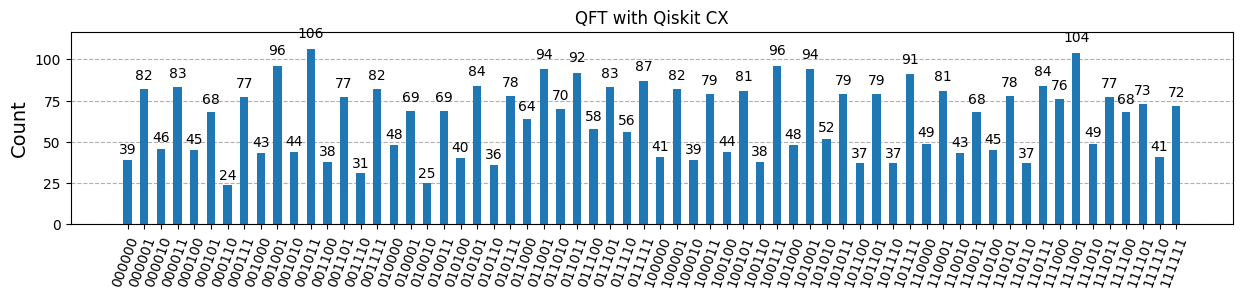

In [5]:
plot_histogram(counts[6]['qiskit_cx'], title='QFT with Qiskit CX', figsize=(15, 2.5))

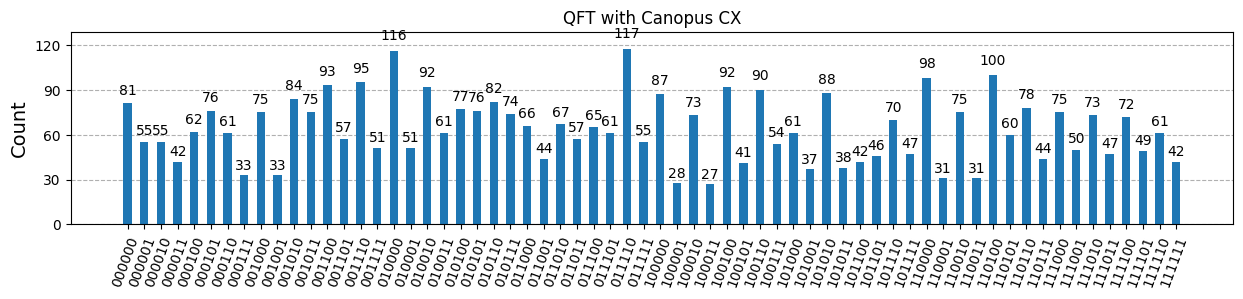

In [6]:
plot_histogram(counts[6]['canopus_cx'], title='QFT with Canopus CX', figsize=(15, 2.5))

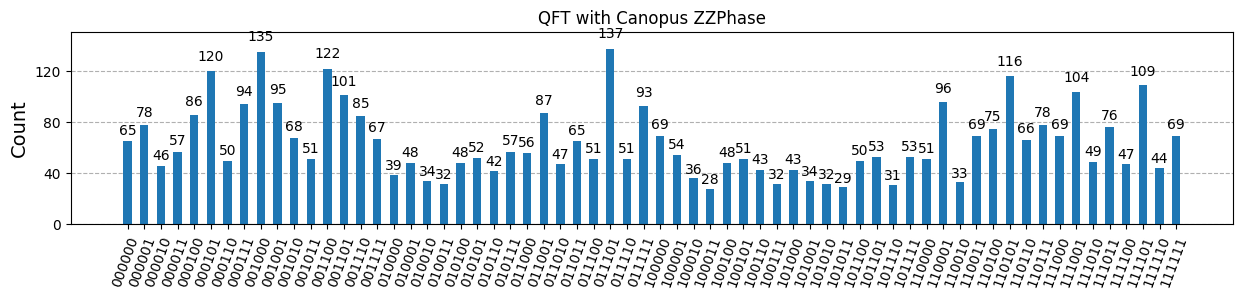

In [7]:
plot_histogram(counts[6]['canopus_zzphase'], title='QFT with Canopus ZZPhase', figsize=(15, 2.5))

In [10]:
def generate_uniform_bitstring_distribution(n):
    """
    生成长度为n的所有bitstring作为key，值都为1的字典
    Args:
        n (int): bitstring的长度
        
    Returns:
        dict: key为长度为n的bitstring，value都为1
    """
    uniform_dict = {}
    
    # 生成所有可能的2^n个bitstring
    for i in range(2**n):
        # 将整数转换为二进制字符串，去掉'0b'前缀，并用0填充到长度n
        bitstring = format(i, f'0{n}b')
        uniform_dict[bitstring] = 1
    
    return uniform_dict

In [15]:
from collections import OrderedDict
from pprint import pprint

fidelities = {}
circuits = {}

for n in [6, 8, 10, 12]:
    ideal_counts = generate_uniform_bitstring_distribution(n)
    fidelities[n] = OrderedDict({
        'qiskit_cx': qi.hellinger_fidelity(counts[n]['qiskit_cx'], ideal_counts),
        'canopus_cx': qi.hellinger_fidelity(counts[n]['canopus_cx'], ideal_counts),
        'canopus_zzphase': qi.hellinger_fidelity(counts[n]['canopus_zzphase'], ideal_counts)
    })

    circuits[n] = {
        'qiskit_cx': QuantumCircuit.from_qasm_file('qft_{}_qiskit_cx.qasm'.format(n)),
        'canopus_cx': QuantumCircuit.from_qasm_file('qft_{}_canopus_cx.qasm'.format(n)),
        'canopus_zzphase': QuantumCircuit.from_qasm_file('qft_{}_canopus_zzphase.qasm'.format(n))
    }


pprint(fidelities)

{6: OrderedDict([('qiskit_cx', 0.9697094790629177),
                 ('canopus_cx', 0.9719182513496536),
                 ('canopus_zzphase', 0.9588698723966106)]),
 8: OrderedDict([('qiskit_cx', 0.970217656146083),
                 ('canopus_cx', 0.9434260814498334),
                 ('canopus_zzphase', 0.894899791603427)]),
 10: OrderedDict([('qiskit_cx', 0.9398237591202487),
                  ('canopus_cx', 0.9287705752809113),
                  ('canopus_zzphase', 0.8281456588086983)]),
 12: OrderedDict([('qiskit_cx', 0.9364488688818915),
                  ('canopus_cx', 0.9530693416824806),
                  ('canopus_zzphase', 0.8738777116147352)])}


In [12]:
with open('qft_fidelities.json', 'w') as f:
    json.dump(fidelities, f, indent=4)

In [8]:
# # for n in [6,8,10,12]:
# #     fidelities[n] = dict(fidelities[n])
# with open('qft_fidelities.json', 'w') as f:
#     json.dump(fidelities, f, indent=4)  # indent 参数用于美化格式

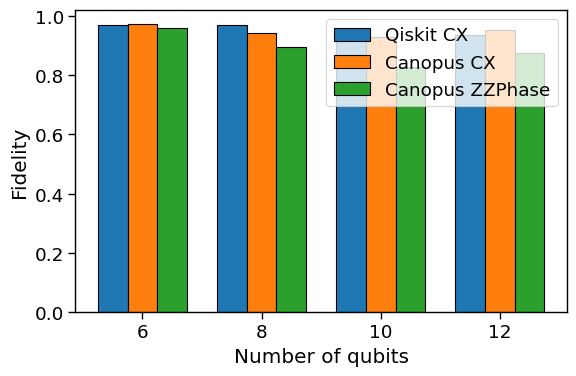

In [16]:
sns.set_context("paper", font_scale=1.5)

plt.figure(figsize=(6, 4))

width = 1/4
num_programs = 4
qubit_numbers = [6, 8, 10, 12]

plt.bar(np.arange(num_programs) + 1 - width, [fidelities[n]['qiskit_cx'] for n in qubit_numbers], width=width, label='Qiskit CX', edgecolor='k')
plt.bar(np.arange(num_programs) + 1, [fidelities[n]['canopus_cx'] for n in qubit_numbers], width=width, label='Canopus CX',  edgecolor='k')
plt.bar(np.arange(num_programs)+ 1 + width, [fidelities[n]['canopus_zzphase'] for n in qubit_numbers], width=width, label='Canopus ZZPhase', edgecolor='k')
plt.xlabel('Number of qubits')
plt.xticks(np.arange(1, num_programs+1), qubit_numbers)
plt.ylabel('Fidelity')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
rzz_gates = {'π_6': 0, 'π_4': 0, 'π_2': 0}

for instr in circuits[8]['canopus_zzphase'].data:
    if instr.operation.name == 'rzz':
        if instr.operation.params[0] == np.pi / 6:
            rzz_gates['π_6'] += 1
        elif instr.operation.params[0] == np.pi / 4:
            rzz_gates['π_4'] += 1
        elif instr.operation.params[0] == np.pi / 2:
            rzz_gates['π_2'] += 1
            
rzz_gates

{'π_6': 6, 'π_4': 13, 'π_2': 67}

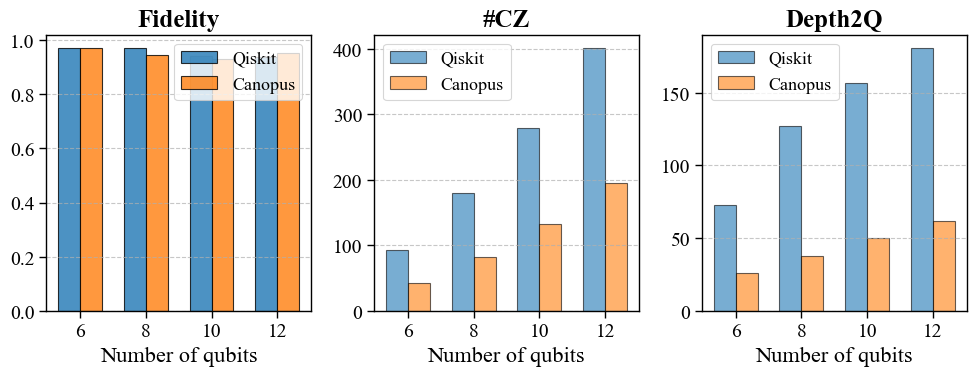

In [17]:
sns.set_context("paper", font_scale=1.5)

plt.rcParams['font.family'] = 'Times New Roman'


plt.figure(figsize=(10, 4))

width = 1/3
num_programs = 4
qubit_numbers = [6, 8, 10, 12]

plt.subplot(1, 3, 1)
plt.bar(np.arange(num_programs) + 1 - width/2, [fidelities[n]['qiskit_cx'] for n in qubit_numbers], width=width, label='Qiskit', edgecolor='k', alpha=0.8)
plt.bar(np.arange(num_programs) + 1 + width/2, [fidelities[n]['canopus_cx'] for n in qubit_numbers], width=width, label='Canopus',  edgecolor='k', alpha=0.8)
plt.xlabel('Number of qubits', fontdict={'size': 16})
plt.xticks(np.arange(1, num_programs + 1), qubit_numbers, fontdict={'size': 14})
plt.yticks(fontsize=14)
plt.title('Fidelity', fontdict={'weight': 'bold', 'size': 18})
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=13)

plt.subplot(1, 3, 2)
plt.bar(np.arange(num_programs) + 1 - width/2, [circuits[n]['qiskit_cx'].num_nonlocal_gates() for n in qubit_numbers], width=width, label='Qiskit', edgecolor='k', alpha=0.6)
plt.bar(np.arange(num_programs) + 1 + width/2, [circuits[n]['canopus_cx'].num_nonlocal_gates() for n in qubit_numbers], width=width, label='Canopus', edgecolor='k', alpha=0.6)
plt.xlabel('Number of qubits', fontdict={'size': 16})
plt.xticks(np.arange(1, num_programs + 1), qubit_numbers, fontdict={'size': 14})
plt.yticks(fontsize=14)
plt.title('#CZ', fontdict={'weight': 'bold', 'size': 18})
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=13)

plt.subplot(1, 3, 3)
plt.bar(np.arange(num_programs) + 1 - width/2, [circuits[n]['qiskit_cx'].depth(lambda instr: instr.operation.num_qubits > 1) for n in qubit_numbers], width=width, label='Qiskit', edgecolor='k', alpha=0.6)
plt.bar(np.arange(num_programs) + 1 + width/2, [circuits[n]['canopus_cx'].depth(lambda instr: instr.operation.num_qubits > 1) for n in qubit_numbers], width=width, label='Canopus', edgecolor='k', alpha=0.6)
plt.xlabel('Number of qubits', fontdict={'size': 16})
plt.xticks(np.arange(1, num_programs + 1), qubit_numbers, fontdict={'size': 14})
plt.yticks(fontsize=14)
plt.title('Depth2Q', fontdict={'weight': 'bold', 'size': 18})
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('qft_cloud.pdf')

plt.show()

In [84]:
circuits[6]['qiskit_cx'].num_nonlocal_gates(), circuits[6]['qiskit_cx'].depth(lambda instr: instr.operation.num_qubits > 1)

(93, 73)

In [86]:
circuits[6]['canopus_cx'].num_nonlocal_gates(), circuits[6]['canopus_cx'].depth(lambda instr: instr.operation.num_qubits > 1)

(43, 26)

---

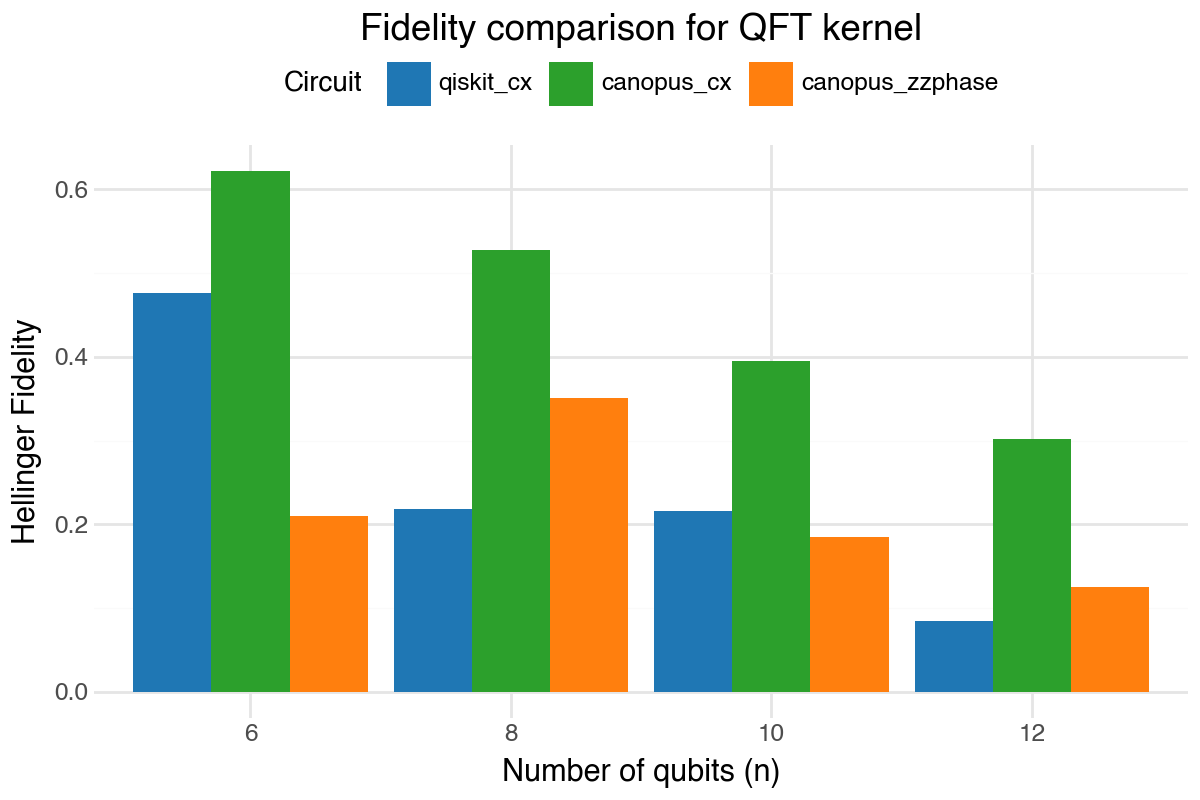

In [12]:
# content of fidelities
from plotnine import *
import pandas as pd



# Convert to DataFrame
data = []
for n, values in fidelities.items():
    for label, fidelity in values.items():
        data.append({'n': n, 'label': label, 'fidelity': fidelity})

df = pd.DataFrame(data)

# Define the order of labels
label_order = ['qiskit_cx', 'canopus_cx', 'canopus_zzphase']
df['label'] = pd.Categorical(df['label'], categories=label_order, ordered=True)

# Create the plot with custom colors
p = (ggplot(df, aes(x='factor(n)', y='fidelity', fill='label'))
        + geom_bar(stat='identity', position='dodge')
        + scale_fill_manual(values=['#1f77b4', '#2ca02c', '#ff7f0e'])
        + labs(title='Fidelity comparison for QFT kernel',
               x='Number of qubits (n)',
               y='Hellinger Fidelity',
               fill='Circuit')
        + theme_minimal()
        + theme(figure_size=(6, 4), axis_text_x=element_text(rotation=0),
                legend_title=element_text(size=10), legend_position='top'))
p


In [131]:
# 8192 / 

2**12 * 10

40960

In [134]:
2**10 * 10

10240

In [129]:
counts[12]['canopus_cx']

{'000000100000': 167,
 '110000010001': 1,
 '101000010001': 2,
 '111010111101': 1,
 '000000000000': 2252,
 '101110111100': 1,
 '010000010000': 15,
 '000110001000': 10,
 '110111010000': 1,
 '000100110011': 1,
 '111111010001': 1,
 '111011100010': 3,
 '100000011011': 1,
 '100000000100': 9,
 '011101110111': 1,
 '000110000010': 8,
 '000100000000': 71,
 '001000000100': 3,
 '001100011000': 5,
 '111001111011': 2,
 '101110000000': 4,
 '000001100010': 8,
 '000000011100': 7,
 '010000100001': 7,
 '000000100001': 30,
 '001100100000': 13,
 '111000100001': 1,
 '011110000000': 4,
 '000000101000': 17,
 '011101010000': 2,
 '010000000000': 111,
 '010000000001': 18,
 '000000001000': 120,
 '111000000001': 4,
 '000000111001': 2,
 '110000000000': 100,
 '000000000100': 121,
 '001101101010': 1,
 '000000100100': 14,
 '100011110111': 1,
 '111100000100': 3,
 '110001011111': 1,
 '100001110110': 2,
 '110110110100': 1,
 '110011001101': 2,
 '011110101111': 1,
 '011001000110': 1,
 '001100000000': 43,
 '101001100000': 3

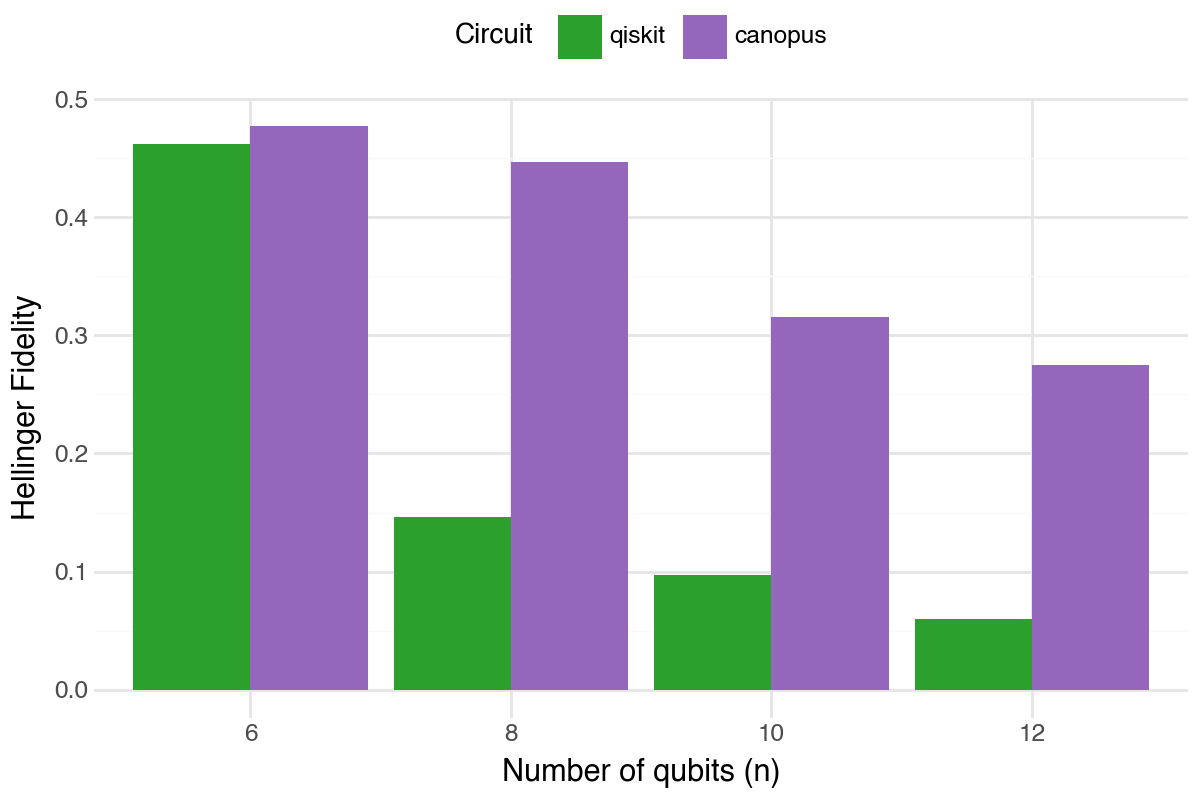

In [122]:
# content of fidelities
from plotnine import *
import pandas as pd


# Convert to DataFrame
data = []
for n, values in fidelities.items():
    for label, fidelity in values.items():
        if 'zzphase' in label:
            continue
        else:
            label = label.replace('_cx', '')
        data.append({'n': n, 'label': label, 'fidelity': fidelity})

df = pd.DataFrame(data)

# Define the order of labels
label_order = ['qiskit', 'canopus']
df['label'] = pd.Categorical(df['label'], categories=label_order, ordered=True)

# Create the plot with custom colors
p = (ggplot(df, aes(x='factor(n)', y='fidelity', fill='label'))
        + geom_bar(stat='identity', position='dodge')
        # + scale_fill_manual(values=[ '#2ca02c', '#ff7f0e'])
        # use blue and purple
        # + scale_fill_manual(values=['#1f77b4', '#9467bd'])
        + scale_fill_manual(values=[ '#2ca02c', '#9467bd'])
        + labs(title='',
               x='Number of qubits (n)',
               y='Hellinger Fidelity',

               fill='Circuit')
        + theme_minimal()
        + theme(figure_size=(6, 4), axis_text_x=element_text(rotation=0),
                legend_title=element_text(size=10), legend_position='top'))
p


In [100]:
pprint(fidelities)

{6: OrderedDict([('qiskit_cx', 0.46191406250000006),
                 ('canopus_cx', 0.47741699218750006),
                 ('canopus_zzphase', 0.14807128906249997)]),
 8: OrderedDict([('qiskit_cx', 0.146484375),
                 ('canopus_cx', 0.44665527343750006),
                 ('canopus_zzphase', 0.31713867187499994)]),
 10: OrderedDict([('qiskit_cx', 0.0966796875000001),
                  ('canopus_cx', 0.31591796875),
                  ('canopus_zzphase', 0.009399414062500033)]),
 12: OrderedDict([('qiskit_cx', 0.06018066406250001),
                  ('canopus_cx', 0.2749023437500001),
                  ('canopus_zzphase', 0.11987304687500004)])}


In [ ]:
# 添加数值标签的版本
p_with_labels = (ggplot(df, aes(x='factor(n_qubits)', y='fidelity', fill='method')) +
     geom_bar(stat='identity', position='dodge', width=0.7) +
     geom_text(aes(label='round(fidelity, 3)'), 
               position=position_dodge(width=0.7), 
               va='bottom', ha='center', size=9) +
     labs(title='QFT Circuit Fidelity Comparison on IBM Quantum Hardware',
          x='Number of Qubits',
          y='Hellinger Fidelity',
          fill='Compilation Method') +
     theme_minimal() +
     theme(figure_size=(12, 6),
           axis_text_x=element_text(size=12),
           axis_text_y=element_text(size=12),
           axis_title=element_text(size=14),
           plot_title=element_text(ha='center', size=16),
           legend_position='top',
           legend_direction='horizontal') +
     scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c'],
                       labels=['Qiskit CX', 'Canopus CX', 'Canopus ZZPhase']) +
     scale_y_continuous(limits=[0, 0.55], breaks=[0, 0.1, 0.2, 0.3, 0.4, 0.5]))

print(p_with_labels)

---

In [40]:
cx_cost_est = canopus.SynthCostEstimator('cx') # CX ISA 下的 SynthCostEstimator
zzphase_cost_est = canopus.SynthCostEstimator('zzphase')  # ZZPhase ISA 下的 SynthCostEstimator

n = 10
qft = QFT(n, do_swaps=False).decompose()
qft.h(range(qft.num_qubits)) # 这一步是为了测量需要，这样的ideal结果的 {'000..00': SHOTS}
qft = canopus.rebase_to_tk2(qft) # 把 qft 电路转换到 canonical 表示, i.e., {Can, U3} ISA

In [41]:
coupling_map = canopus.utils.gene_chain_coupling_map(qft.num_qubits)
canopus_backend = canopus.CanopusBackend(coupling_map, 'cx')
qft_canopus = PassManager(canopus.CanopusMapping(canopus_backend)).run(qft)
qft_canopus.draw(fold=1000)

┌─────────────────┐                                                                                                                                                                                                                                                                                                                                                     ┌──────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                        
q_0 -> 0 ─┤ U(π/2,0,4.7216) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0                     ├───────────────────────────────X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          ├─────────────────┴┐                                                                                                                                                                                                                                                                           ┌─────────────────────┐                                                  │  Can(0.00097656,0,0) │  ┌────────────────┐           │           ┌─────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                      
q_1 -> 1 ─┤ U(7π/2,0,2.3501) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0                    ├───────────────────────────────────────X──────────┤1                     ├──┤ U(0,-π/2,3π/2) ├───────────X───────────┤0                    ├────────────────────────────────X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          ├──────────────────┤                                                                                                                                                                                                                              ┌─────────────────────┐                      │  Can(0.0019531,0,0) │      ┌────────────────┐               │          ├─────────────────────┬┘  └────────────────┘                       │  Can(0.0019531,0,0) │    ┌────────────────┐          │         ┌─────────────────────┐┌─────────────────────┐                                                                                                                          

In [42]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeTorino


generic_backend = GenericBackendV2(num_qubits=qft.num_qubits, coupling_map=coupling_map)

pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=generic_backend,
    layout_method="trivial",
    routing_method="sabre",
)
qft_qiskit = pass_manager.run(qft)
qft_qiskit.draw(fold=10000)

global phase: 1.0747
         ┌─────────────┐┌────┐ ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌───┐         ┌────┐   ┌──────────┐                                                                                                    ┌────────┐   ┌────┐   ┌────────────┐             ┌────┐   ┌─────────┐               ┌────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
q_0 -> 0 ┤ Rz(-3.1324) ├┤ √X ├─┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [43]:
# 对比两者的 gate-count cost & circuit-depth cost, in the CX ISA
print('Qiskit (CX):', cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_qiskit)))
print('Canopus (CX):', cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_canopus)))
print('Canopus (ZZPhase):', zzphase_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_canopus)))

Qiskit (CX): (234.0, 127.0)
Canopus (CX): (133.0, 49.0)
Canopus (ZZPhase): (125.16666666666664, 45.666666666666664)


In [7]:
TOKEN = 'XmCm7IP6TTKlzpRIySwkL7ruhdMj2o0_8sqiC6Yy91ic' # My API

service = QiskitRuntimeService(
    channel="ibm_cloud",
    token = TOKEN
)

# 验证连接是否成功
print("Available backends:")
backends = service.backends()
for backend in backends:
    print(f"- {backend.name}: {backend.status().status_msg}")

Available backends:
- ibm_torino: active


In [ ]:
# 运行在真机之前最最后阶段的 transpilation

torino_cx = service.backend("ibm_torino", use_fractional_gates=False)
torino_zzphase = service.backend("ibm_torino", use_fractional_gates=True)

pm_cx_isa = generate_preset_pass_manager(optimization_level=1, backend=torino_cx, scheduling_method="alap")
pm_zzphase_isa = generate_preset_pass_manager(optimization_level=1, backend=torino_zzphase, scheduling_method="alap")


qft_qiskit_cx = qft_qiskit.copy()
qft_canopus_cx = canopus.logical_optimize(qft_canopus)
qft_canopus_zzphase = canopus.rebase_to_zzphase(qft_canopus)

/Users/anan/git-projects/quantum/canopus/examples/../canopus/utils.py:214: UserWarning: !!!!!! Unsupported pytket circuit type: {OpType.TK1, OpType.CX} for native conversion
  warnings.warn(


In [45]:
qft_qiskit_cx.measure_all()
qft_canopus_cx.measure_all()
qft_canopus_zzphase.measure_all()

qft_qiskit_cx_submitted = pm_cx_isa.run(qft_qiskit_cx)
qft_canopus_cx_submitted = pm_cx_isa.run(qft_canopus_cx)
qft_canopus_zzphase_submitted = pm_zzphase_isa.run(qft_canopus_zzphase)

In [46]:
canopus.utils.print_circ_info(qft_qiskit_cx)
canopus.utils.print_circ_info(qft_qiskit_cx_submitted)
print(qft_qiskit_cx_submitted.count_ops())

+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|     10     |    799    |     279      |  352  |   151    |
+------------+-----------+--------------+-------+----------+
+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|    133     |    1820   |     279      |  544  |   151    |
+------------+-----------+--------------+-------+----------+
OrderedDict({'rz': 809, 'sx': 403, 'delay': 313, 'cz': 279, 'measure': 10, 'x': 6, 'barrier': 1})


In [47]:
canopus.utils.print_circ_info(qft_canopus_cx)
canopus.utils.print_circ_info(qft_canopus_cx_submitted)
print(qft_canopus_cx_submitted.count_ops())


+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|     10     |    415    |     133      |   99  |    50    |
+------------+-----------+--------------+-------+----------+
+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|    133     |    1008   |     133      |  204  |    50    |
+------------+-----------+--------------+-------+----------+
OrderedDict({'rz': 327, 'sx': 327, 'delay': 210, 'cz': 133, 'measure': 10, 'x': 1, 'barrier': 1})


In [48]:
canopus.utils.print_circ_info(qft_canopus_zzphase)
canopus.utils.print_circ_info(qft_canopus_zzphase_submitted)
print(qft_canopus_zzphase_submitted.count_ops())

+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|     10     |    437    |     139      |  112  |    56    |
+------------+-----------+--------------+-------+----------+
+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|    133     |    910    |     139      |  175  |    56    |
+------------+-----------+--------------+-------+----------+
OrderedDict({'rz': 307, 'rx': 286, 'delay': 168, 'rzz': 139, 'measure': 10, 'barrier': 1})


n=2的情况:
{'00': 1, '01': 1, '10': 1, '11': 1}
总共有 4 个key

n=3的情况:
{'000': 1, '001': 1, '010': 1, '011': 1, '100': 1, '101': 1, '110': 1, '111': 1}
总共有 8 个key
